# Imports & Setup

In [1]:
import os
import fitz  # PyMuPDF
import docx
import pandas as pd
from pptx import Presentation
import pytesseract
from PIL import Image, ImageFilter
import re
from sentence_transformers import SentenceTransformer
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

C:\Users\mkman\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONFIG

In [2]:
INPUT_FOLDER = "E:\CODING\Python\DRDO Internship Project\project_data"
OUTPUT_CSV = "output_embeddings_labels_2.csv"
GROUPED_OUTPUT = "grouped_files_by_cluster_2.txt"

# Initialize model

In [3]:
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Different Text Extraction Functions of Differnt Types of Files

In [4]:
def extract_text_from_pdf(filepath):
    try:
        with fitz.open(filepath) as doc:
            return " ".join(page.get_text() for page in doc)
    except:
        return ""

def extract_text_from_docx(filepath):
    try:
        doc = docx.Document(filepath)
        return " ".join(para.text for para in doc.paragraphs)
    except:
        return ""

def extract_text_from_excel(filepath):
    try:
        dfs = pd.read_excel(filepath, sheet_name=None)
        rows = []
        for sheet_name, df in dfs.items():
            df = df.fillna("")
            for _, row in df.iterrows():
                line = " ".join(str(cell) for cell in row if str(cell).strip() != "")
                if line:
                    rows.append(line)
        return " ".join(rows)
    except Exception as e:
        print(f"Error reading Excel {filepath}: {e}")
        return ""

def extract_text_from_pptx(filepath):
    try:
        prs = Presentation(filepath)
        return " ".join(shape.text for slide in prs.slides for shape in slide.shapes if hasattr(shape, "text"))
    except:
        return ""

def extract_text_from_image(filepath):
    try:
        img = Image.open(filepath).convert("L").filter(ImageFilter.SHARPEN)
        return pytesseract.image_to_string(img)
    except:
        return ""

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


# Text Cleaning Function

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# Extract_text Function

In [6]:
def extract_text(filepath):
    ext = filepath.lower().split(".")[-1]
    if ext == "pdf":
        return extract_text_from_pdf(filepath)
    elif ext == "docx":
        return extract_text_from_docx(filepath)
    elif ext in ["xlsx", "xls"]:
        return extract_text_from_excel(filepath)
    elif ext == "pptx":
        return extract_text_from_pptx(filepath)
    elif ext in ["jpg", "jpeg", "png"]:
        return extract_text_from_image(filepath)
    elif ext == "txt":
        try:
            with open(filepath, "r", encoding="utf-8") as f:
                return f.read()
        except:
            return ""
    else:
        return ""


# Text Extraction Loop

In [7]:
filepaths, texts = [], []
for root, dirs, files in os.walk(INPUT_FOLDER):
    for file in files:
        filepath = os.path.join(root, file)
        text = extract_text(filepath)
        if text:
            cleaned = clean_text(text)
            filepaths.append(filepath)
            texts.append(cleaned)

print(f"Extracted and cleaned {len(texts)} documents.")


Extracted and cleaned 12 documents.


In [8]:
filepaths

['E:\\CODING\\Python\\DRDO Internship Project\\project_data\\AI_Presentation.pptx',
 'E:\\CODING\\Python\\DRDO Internship Project\\project_data\\AI_Technical_Report.docx',
 'E:\\CODING\\Python\\DRDO Internship Project\\project_data\\AI_Technical_Report.pdf',
 'E:\\CODING\\Python\\DRDO Internship Project\\project_data\\Cybersecurity_Modern_Era.docx',
 'E:\\CODING\\Python\\DRDO Internship Project\\project_data\\Cybersecurity_Trends_Challenges.pdf',
 'E:\\CODING\\Python\\DRDO Internship Project\\project_data\\Defense_Equipment_Specifications.xlsx',
 'E:\\CODING\\Python\\DRDO Internship Project\\project_data\\Defense_Technologies_Missile_Guidance.pdf',
 'E:\\CODING\\Python\\DRDO Internship Project\\project_data\\Defense_Technologies_Presentation.pptx',
 'E:\\CODING\\Python\\DRDO Internship Project\\project_data\\Defense_Technologies_Radar.pdf',
 'E:\\CODING\\Python\\DRDO Internship Project\\project_data\\Electronic_Warfare_Equipment.xlsx',
 'E:\\CODING\\Python\\DRDO Internship Project\\pro

In [9]:
texts

['artificial intelligence exploring the potential of intelligent machines what is artificial intelligence simulation of human intelligence by machines encompasses machine learning nlp robotics computer vision used in everyday applications applications of ai healthcare diagnostics autonomous vehicles smart assistants financial fraud detection the future of ai increased automation ethical and regulatory frameworks humanai collaboration',
 'artificial intelligence transforming the future 1 introduction artificial intelligence ai refers to the simulation of human intelligence in machines that are designed to think learn and adapt ai spans multiple fields including computer science linguistics psychology and engineering it encompasses a wide array of applications from expert systems and machine learning to robotics and natural language processing nlp 2 history of ai the term artificial intelligence was first coined in 1956 by john mccarthy at the dartmouth conference early ai research focus

# Generating embeddings

In [10]:
embeddings = sbert_model.encode(texts, show_progress_bar=True)

Batches: 100%|███████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


In [11]:
embeddings

array([[-0.0330854 , -0.01183691, -0.00308276, ...,  0.090037  ,
         0.05513799, -0.04215843],
       [-0.0598756 , -0.02743331,  0.03357216, ...,  0.03024944,
         0.06649332, -0.0641619 ],
       [-0.09850881,  0.01943897, -0.01706742, ...,  0.03366251,
         0.06142511, -0.10635884],
       ...,
       [-0.05521594,  0.07121346, -0.08616917, ...,  0.01976446,
        -0.03198169,  0.05416363],
       [-0.04818469,  0.05589243, -0.04630978, ..., -0.08093128,
        -0.0718637 ,  0.07299785],
       [-0.02120008,  0.0720959 , -0.02534992, ..., -0.03649825,
        -0.03913926,  0.04448051]], shape=(12, 384), dtype=float32)

## Visualization: PCA 2D of Embeddings

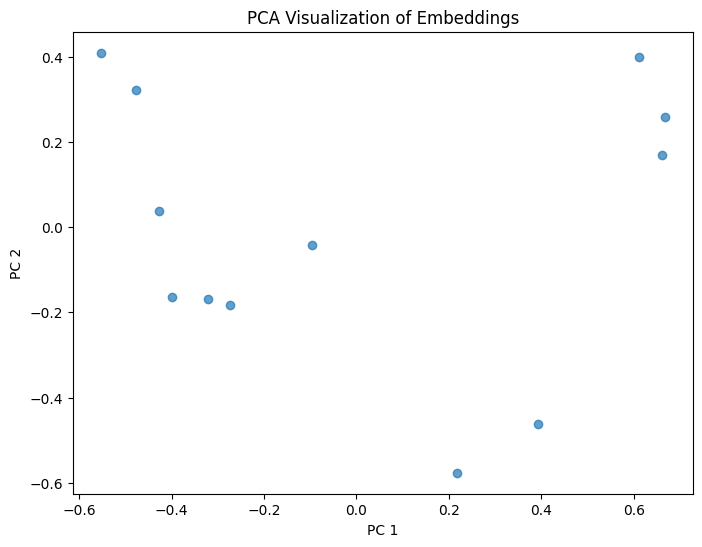

In [12]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], alpha=0.7)
plt.title("PCA Visualization of Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

# Clustering with KMeans

In [13]:
n_clusters = 4
clusterer = KMeans(n_clusters=n_clusters, random_state=42)
labels = clusterer.fit_predict(embeddings)

## Visualization: Clustering result

C:\Users\mkman\AppData\Local\Temp\ipykernel_3444\2501116017.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', n_clusters)


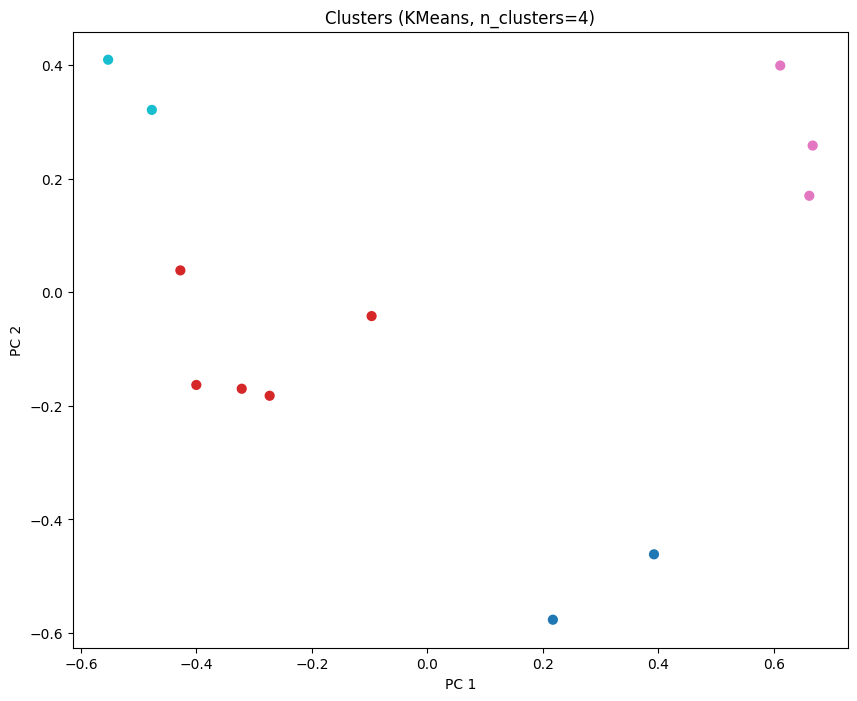

In [14]:
plt.figure(figsize=(10, 8))
palette = plt.cm.get_cmap('tab10', n_clusters)
colors = [palette(l) for l in labels]
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=colors, s=40)
plt.title(f"Clusters (KMeans, n_clusters={n_clusters})")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

## Saving embeddings and cluster labels to: {OUTPUT_CSV}

In [15]:
with open(OUTPUT_CSV, "w", newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filepath", "label"] + [f"dim_{i}" for i in range(embeddings.shape[1])])
    for filepath, label, vec in zip(filepaths, labels, embeddings):
        writer.writerow([filepath, label] + list(vec))

clusters = defaultdict(list)
for filepath, label in zip(filepaths, labels):
    clusters[label].append(filepath)

## Saving grouped file list to: {GROUPED_OUTPUT}

In [16]:
with open(GROUPED_OUTPUT, "w", encoding="utf-8") as f:
    for label, files in sorted(clusters.items()):
        f.write(f"Cluster {label}:")
        f.write("\n")
        for file in files:
            f.write(f"  {file}\n")
        f.write("\n")